In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings('ignore')
import nltk
from nltk.tokenize import word_tokenize
from collections import Counter
from nltk.stem.snowball import SnowballStemmer
from keras.preprocessing import sequence
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.metrics import confusion_matrix

nltk.download('punkt')
nltk.download('stopwords')


[nltk_data] Error loading punkt: <urlopen error [Errno 11004]
[nltk_data]     getaddrinfo failed>
[nltk_data] Error loading stopwords: <urlopen error [Errno 11004]
[nltk_data]     getaddrinfo failed>


False

In [2]:
df = pd.read_csv("D:\\chaos\\text.csv")

In [3]:
# We have droped the extra column 
df.drop(columns='Unnamed: 0', inplace=True)

In [4]:
df.head(2)

,text,label
0,i just feel really helpless and heavy hearted,4
1,ive enjoyed being able to slouch about relax a...,0


In [5]:
df.duplicated().sum()

686

In [6]:
df.drop_duplicates(inplace=True)

In [7]:
df.duplicated().sum()

0

In [8]:
# we need to map the data so we can get the good visualization
emotion_map = {
    0: 'sadness',
    1: 'joy',
    2: 'love',
    3: 'anger',
    4: 'fear',
    5: 'surprise'
    # Add more mappings as needed
}

df['label'] = df['label'].map(emotion_map)


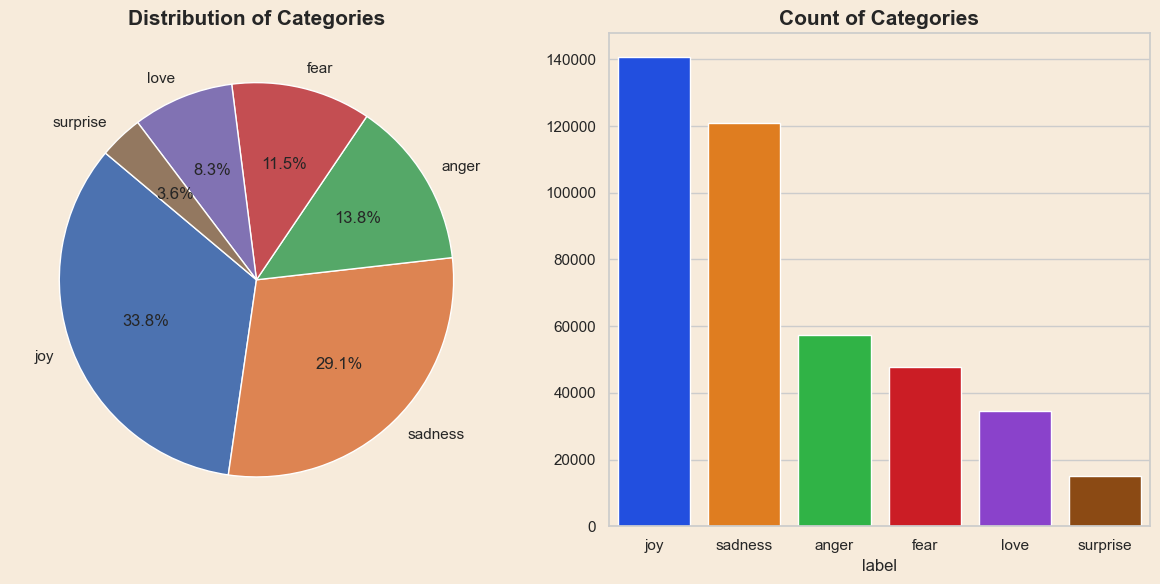

In [9]:
# Value count of 'label'
count = df['label'].value_counts()

# Set the background color and theme
background_color = '#f7ebdb'
sns.set_theme(style="whitegrid", rc={"axes.facecolor": background_color, 'figure.facecolor': background_color})

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6), facecolor=background_color)

# Plot pie chart on the first subplot
palette = sns.color_palette("bright", len(count))
sns.set_palette(palette)
axs[0].pie(count, labels=count.index, autopct='%1.1f%%', startangle=140)
axs[0].set_title('Distribution of Categories', fontsize=15, fontweight='bold')

# Plot bar chart on the second subplot
sns.barplot(x=count.index, y=count.values, ax=axs[1], palette=palette)
axs[1].set_title('Count of Categories', fontsize=15, fontweight='bold')

# Adjust layout
plt.tight_layout()
plt.savefig('D:\document\dissertation\LSTM_result\emotion_distribution.png')
# Show the plot
plt.show()

In [10]:
# Define a dictionary of chat word mappings
chat_words = {
    "AFAIK": "As Far As I Know",
    "AFK": "Away From Keyboard",
    "ASAP": "As Soon As Possible",
    "ATK": "At The Keyboard",
    "ATM": "At The Moment",
    "A3": "Anytime, Anywhere, Anyplace",
    "BAK": "Back At Keyboard",
    "BBL": "Be Back Later",
    "BBS": "Be Back Soon",
    "BFN": "Bye For Now",
    "B4N": "Bye For Now",
    "BRB": "Be Right Back",
    "BRT": "Be Right There",
    "BTW": "By The Way",
    "B4": "Before",
    "B4N": "Bye For Now",
    "CU": "See You",
    "CUL8R": "See You Later",
    "CYA": "See You",
    "FAQ": "Frequently Asked Questions",
    "FC": "Fingers Crossed",
    "FWIW": "For What It's Worth",
    "FYI": "For Your Information",
    "GAL": "Get A Life",
    "GG": "Good Game",
    "GN": "Good Night",
    "GMTA": "Great Minds Think Alike",
    "GR8": "Great!",
    "G9": "Genius",
    "IC": "I See",
    "ICQ": "I Seek you (also a chat program)",
    "ILU": "ILU: I Love You",
    "IMHO": "In My Honest/Humble Opinion",
    "IMO": "In My Opinion",
    "IOW": "In Other Words",
    "IRL": "In Real Life",
    "KISS": "Keep It Simple, Stupid",
    "LDR": "Long Distance Relationship",
    "LMAO": "Laugh My A.. Off",
    "LOL": "Laughing Out Loud",
    "LTNS": "Long Time No See",
    "L8R": "Later",
    "MTE": "My Thoughts Exactly",
    "M8": "Mate",
    "NRN": "No Reply Necessary",
    "OIC": "Oh I See",
    "PITA": "Pain In The A..",
    "PRT": "Party",
    "PRW": "Parents Are Watching",
    "QPSA?": "Que Pasa?",
    "ROFL": "Rolling On The Floor Laughing",
    "ROFLOL": "Rolling On The Floor Laughing Out Loud",
    "ROTFLMAO": "Rolling On The Floor Laughing My A.. Off",
    "SK8": "Skate",
    "STATS": "Your sex and age",
    "ASL": "Age, Sex, Location",
    "THX": "Thank You",
    "TTFN": "Ta-Ta For Now!",
    "TTYL": "Talk To You Later",
    "U": "You",
    "U2": "You Too",
    "U4E": "Yours For Ever",
    "WB": "Welcome Back",
    "WTF": "What The F...",
    "WTG": "Way To Go!",
    "WUF": "Where Are You From?",
    "W8": "Wait...",
    "7K": "Sick:-D Laugher",
    "TFW": "That feeling when",
    "MFW": "My face when",
    "MRW": "My reaction when",
    "IFYP": "I feel your pain",
    "TNTL": "Trying not to laugh",
    "JK": "Just kidding",
    "IDC": "I don't care",
    "ILY": "I love you",
    "IMU": "I miss you",
    "ADIH": "Another day in hell",
    "ZZZ": "Sleeping, bored, tired",
    "WYWH": "Wish you were here",
    "TIME": "Tears in my eyes",
    "BAE": "Before anyone else",
    "FIMH": "Forever in my heart",
    "BSAAW": "Big smile and a wink",
    "BWL": "Bursting with laughter",
    "BFF": "Best friends forever",
    "CSL": "Can't stop laughing"
}

In [11]:
# Function to replace chat words with their full forms
def replace_chat_words(text):
    words = text.split()
    for i, word in enumerate(words):
        if word.lower() in chat_words:
            words[i] = chat_words[word.lower()]
    return ' '.join(words)

# Apply replace_chat_words function to 'Text' column
df['text'] = df['text'].apply(replace_chat_words)

In [12]:
df['text'] = df['text'].apply(lambda x: re.sub(r'[^a-zA-Z\s]', '', x))

df.head(2)

,text,label
0,i just feel really helpless and heavy hearted,fear
1,ive enjoyed being able to slouch about relax a...,sadness


In [13]:
stop = stopwords.words('english')
df["text"] = df['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

df.head(2)

,text,label
0,feel really helpless heavy hearted,fear
1,ive enjoyed able slouch relax unwind frankly n...,sadness


In [14]:
df['text'] = df['text'].str.lower()
print(df.head())

                                                text    label
0                 feel really helpless heavy hearted     fear
1  ive enjoyed able slouch relax unwind frankly n...  sadness
2            gave internship dmrg feeling distraught     fear
3                                dont know feel lost  sadness
4  kindergarten teacher thoroughly weary job take...     fear


In [15]:
df['text'] = df['text'].str.replace(r'\d+', '', regex=True)
df.head(2)

,text,label
0,feel really helpless heavy hearted,fear
1,ive enjoyed able slouch relax unwind frankly n...,sadness


In [16]:
df['text'] = df['text'].str.replace(r'[^\w\s]', '', regex=True)
print(df.head())

                                                text    label
0                 feel really helpless heavy hearted     fear
1  ive enjoyed able slouch relax unwind frankly n...  sadness
2            gave internship dmrg feeling distraught     fear
3                                dont know feel lost  sadness
4  kindergarten teacher thoroughly weary job take...     fear


In [17]:
df['text'] = df['text'].str.replace(r'http\S+', '', regex=True)
print(df.head())

                                                text    label
0                 feel really helpless heavy hearted     fear
1  ive enjoyed able slouch relax unwind frankly n...  sadness
2            gave internship dmrg feeling distraught     fear
3                                dont know feel lost  sadness
4  kindergarten teacher thoroughly weary job take...     fear


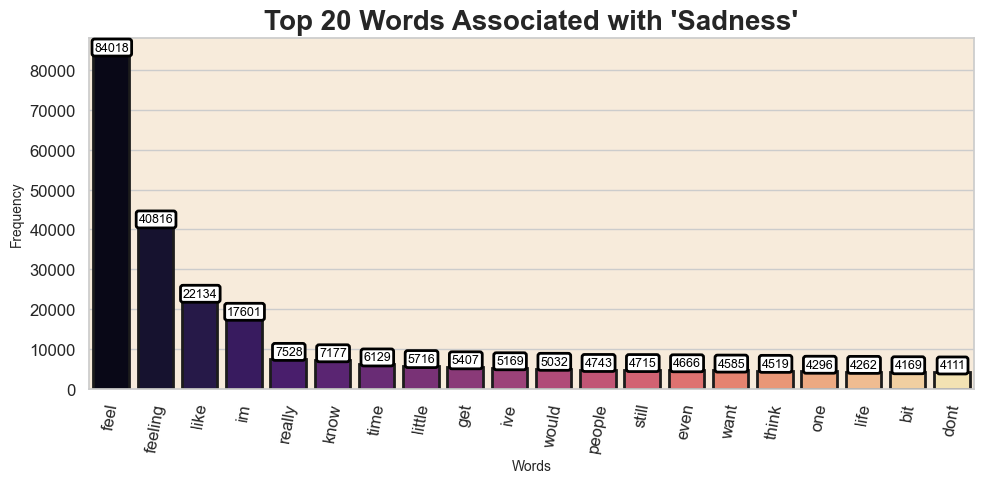

In [18]:
love_texts = df[df['label'] == 'sadness']['text']

# Tokenize the text and count the frequency of each word
words = [word.lower() for text in love_texts for word in word_tokenize(text)]
word_freq = Counter(words)

# Get the top 20 words
top_20_words = dict(word_freq.most_common(20))

# Set the background color and theme
background_color = '#f7ebdb'
sns.set_theme(style="whitegrid", rc={"axes.facecolor": background_color})

# Create a bar plot
plt.figure(figsize=(10, 5))
p = sns.barplot(x=list(top_20_words.keys()), y=list(top_20_words.values()), palette='magma', edgecolor='#1c1c1c', linewidth=2)
for container in p.containers:
    plt.bar_label(container, label_type="edge", color="black", fontsize=9, padding=6, position=(0.5, 0.5),
                  bbox={"boxstyle": "round", "pad": 0.2, "facecolor": "white", "edgecolor": "black", "linewidth": 2, "alpha": 1})
plt.title("Top 20 Words Associated with 'Sadness'", fontsize=20, fontweight='bold')
plt.xlabel("Words", fontsize=10 )
plt.ylabel("Frequency", fontsize=10)
plt.xticks(rotation=80, fontsize=12,)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.savefig('D:\document\dissertation\LSTM_result\sadness_words.png')
plt.show()

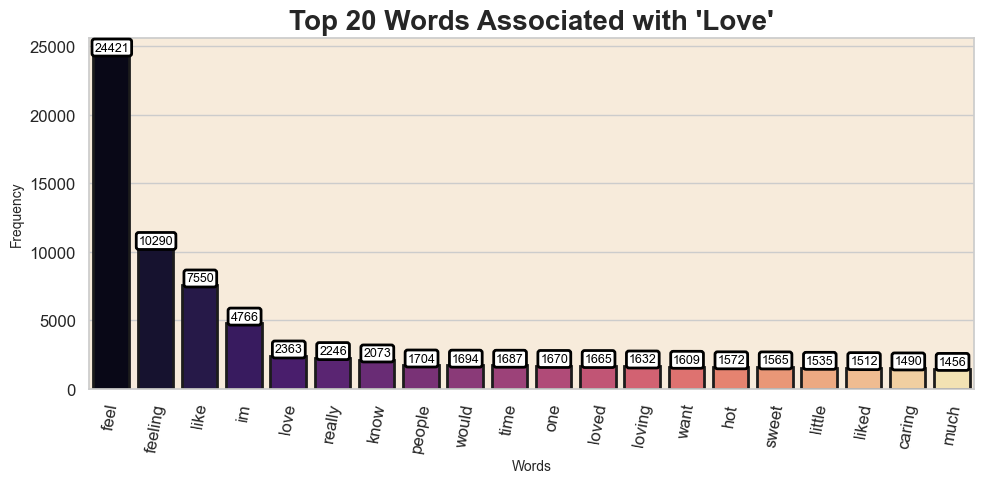

In [19]:
love_texts = df[df['label'] == 'love']['text']

# Tokenize the text and count the frequency of each word
words = [word.lower() for text in love_texts for word in word_tokenize(text)]
word_freq = Counter(words)

# Get the top 20 words
top_20_words = dict(word_freq.most_common(20))

# Set the background color and theme
background_color = '#f7ebdb'
sns.set_theme(style="whitegrid", rc={"axes.facecolor": background_color})

# Create a bar plot
plt.figure(figsize=(10, 5))
p = sns.barplot(x=list(top_20_words.keys()), y=list(top_20_words.values()), palette='magma', edgecolor='#1c1c1c', linewidth=2)
for container in p.containers:
    plt.bar_label(container, label_type="edge", color="black", fontsize=9, padding=6, position=(0.5, 0.5),
                  bbox={"boxstyle": "round", "pad": 0.2, "facecolor": "white", "edgecolor": "black", "linewidth": 2, "alpha": 1})
plt.title("Top 20 Words Associated with 'Love'", fontsize=20, fontweight='bold')
plt.xlabel("Words", fontsize=10 )
plt.ylabel("Frequency", fontsize=10)
plt.xticks(rotation=80, fontsize=12,)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.savefig('D:\document\dissertation\LSTM_result\love_words.png')  
plt.show()

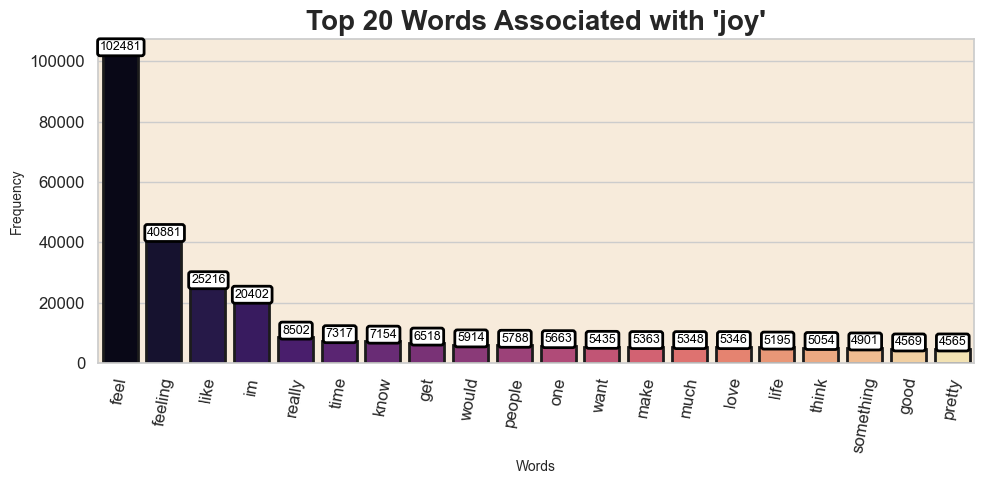

In [20]:
love_texts = df[df['label'] == 'joy']['text']

# Tokenize the text and count the frequency of each word
words = [word.lower() for text in love_texts for word in word_tokenize(text)]
word_freq = Counter(words)

# Get the top 20 words
top_20_words = dict(word_freq.most_common(20))

# Set the background color and theme
background_color = '#f7ebdb'
sns.set_theme(style="whitegrid", rc={"axes.facecolor": background_color})

# Create a bar plot
plt.figure(figsize=(10, 5))
p = sns.barplot(x=list(top_20_words.keys()), y=list(top_20_words.values()), palette='magma', edgecolor='#1c1c1c', linewidth=2)
for container in p.containers:
    plt.bar_label(container, label_type="edge", color="black", fontsize=9, padding=6, position=(0.5, 0.5),
                  bbox={"boxstyle": "round", "pad": 0.2, "facecolor": "white", "edgecolor": "black", "linewidth": 2, "alpha": 1})
plt.title("Top 20 Words Associated with 'joy'", fontsize=20, fontweight='bold')
plt.xlabel("Words", fontsize=10 )
plt.ylabel("Frequency", fontsize=10)
plt.xticks(rotation=80, fontsize=12,)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.savefig('D:\document\dissertation\LSTM_result\joy_words.png')
plt.show()

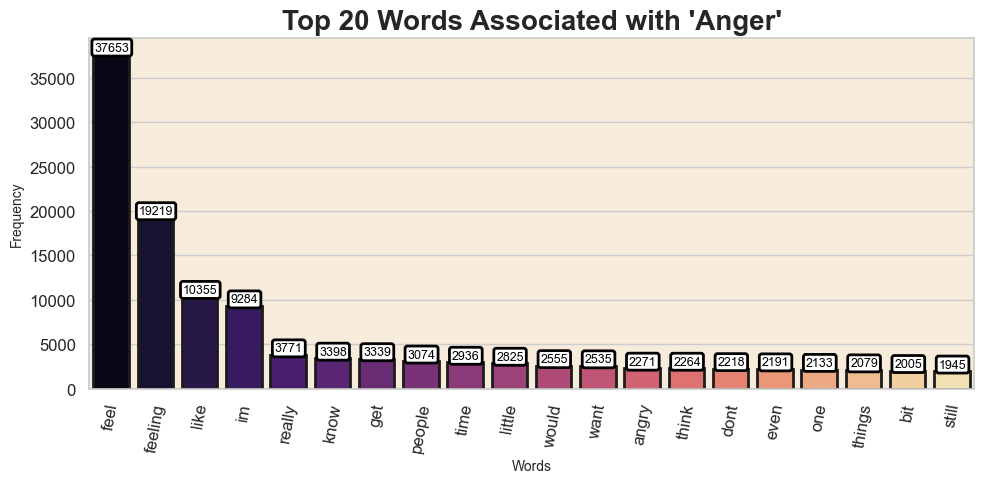

In [21]:
love_texts = df[df['label'] == 'anger']['text']

# Tokenize the text and count the frequency of each word
words = [word.lower() for text in love_texts for word in word_tokenize(text)]
word_freq = Counter(words)

# Get the top 20 words
top_20_words = dict(word_freq.most_common(20))

# Set the background color and theme
background_color = '#f7ebdb'
sns.set_theme(style="whitegrid", rc={"axes.facecolor": background_color})

# Create a bar plot
plt.figure(figsize=(10, 5))
p = sns.barplot(x=list(top_20_words.keys()), y=list(top_20_words.values()), palette='magma', edgecolor='#1c1c1c', linewidth=2)
for container in p.containers:
    plt.bar_label(container, label_type="edge", color="black", fontsize=9, padding=6, position=(0.5, 0.5),
                  bbox={"boxstyle": "round", "pad": 0.2, "facecolor": "white", "edgecolor": "black", "linewidth": 2, "alpha": 1})
plt.title("Top 20 Words Associated with 'Anger'", fontsize=20, fontweight='bold')
plt.xlabel("Words", fontsize=10 )
plt.ylabel("Frequency", fontsize=10)
plt.xticks(rotation=80, fontsize=12,)
plt.yticks(fontsize=12)
plt.tight_layout()
import os
plt.savefig('D:\document\dissertation\LSTM_result\gery_words.png') 
plt.show()

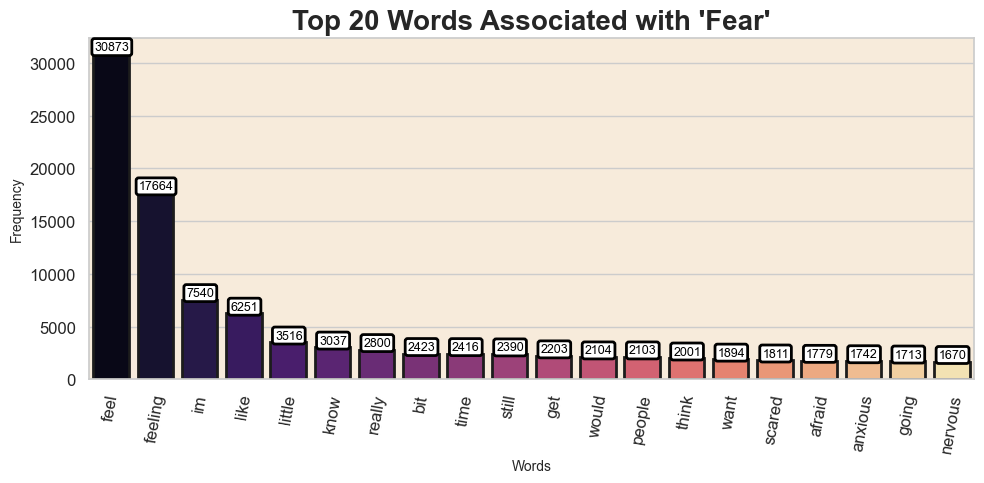

In [22]:
love_texts = df[df['label'] == 'fear']['text']

# Tokenize the text and count the frequency of each word
words = [word.lower() for text in love_texts for word in word_tokenize(text)]
word_freq = Counter(words)

# Get the top 20 words
top_20_words = dict(word_freq.most_common(20))

# Set the background color and theme
background_color = '#f7ebdb'
sns.set_theme(style="whitegrid", rc={"axes.facecolor": background_color})

# Create a bar plot
plt.figure(figsize=(10, 5))
p = sns.barplot(x=list(top_20_words.keys()), y=list(top_20_words.values()), palette='magma', edgecolor='#1c1c1c', linewidth=2)
for container in p.containers:
    plt.bar_label(container, label_type="edge", color="black", fontsize=9, padding=6, position=(0.5, 0.5),
                  bbox={"boxstyle": "round", "pad": 0.2, "facecolor": "white", "edgecolor": "black", "linewidth": 2, "alpha": 1})
plt.title("Top 20 Words Associated with 'Fear'", fontsize=20, fontweight='bold')
plt.xlabel("Words", fontsize=10 )
plt.ylabel("Frequency", fontsize=10)
plt.xticks(rotation=80, fontsize=12,)
plt.yticks(fontsize=12)
plt.tight_layout()
import os

# 1. 确保目录存在
save_dir = r"D:\document\dissertation\LSTM_result"
os.makedirs(save_dir, exist_ok=True)

# 2. 修正保存路径
save_path = os.path.join(save_dir, "fear_words.png")

# 3. 保存图片
plt.savefig(save_path)
plt.show()

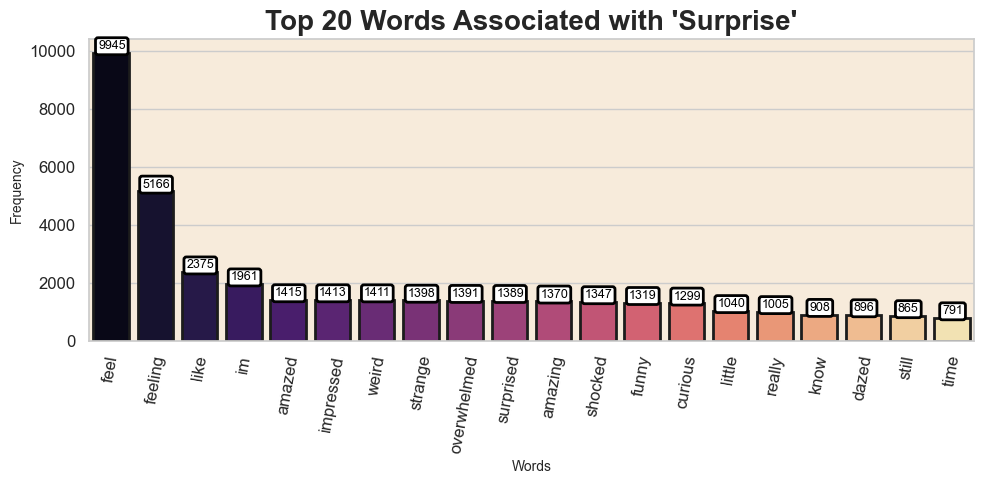

In [23]:
love_texts = df[df['label'] == 'surprise']['text']

# Tokenize the text and count the frequency of each word
words = [word.lower() for text in love_texts for word in word_tokenize(text)]
word_freq = Counter(words)

# Get the top 20 words
top_20_words = dict(word_freq.most_common(20))

# Set the background color and themesss
background_color = '#f7ebdb'
sns.set_theme(style="whitegrid", rc={"axes.facecolor": background_color})

# Create a bar plot
plt.figure(figsize=(10, 5))
p = sns.barplot(x=list(top_20_words.keys()), y=list(top_20_words.values()), palette='magma', edgecolor='#1c1c1c', linewidth=2)
for container in p.containers:
    plt.bar_label(container, label_type="edge", color="black", fontsize=9, padding=6, position=(0.5, 0.5),
                  bbox={"boxstyle": "round", "pad": 0.2, "facecolor": "white", "edgecolor": "black", "linewidth": 2, "alpha": 1})
plt.title("Top 20 Words Associated with 'Surprise'", fontsize=20, fontweight='bold')
plt.xlabel("Words", fontsize=10 )
plt.ylabel("Frequency", fontsize=10)
plt.xticks(rotation=80, fontsize=12,)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.savefig('D:\document\dissertation\LSTM_result\surprise_words.png')
plt.show()

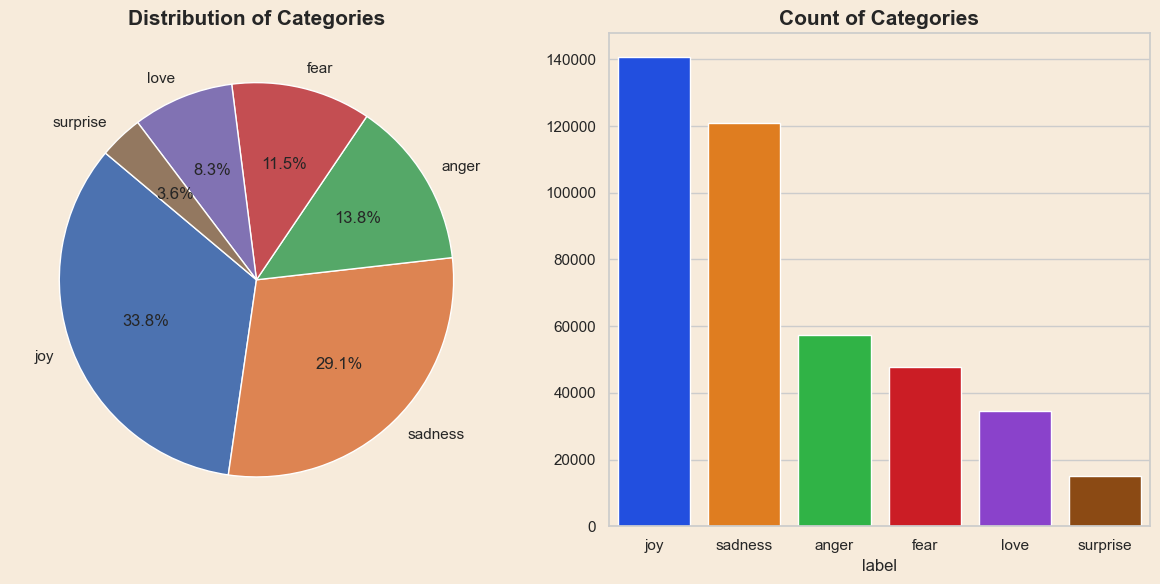

In [24]:
# Value count of 'label'
count = df['label'].value_counts()

# Set the background color and theme
background_color = '#f7ebdb'
sns.set_theme(style="whitegrid", rc={"axes.facecolor": background_color, 'figure.facecolor': background_color})

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6), facecolor=background_color)

# Plot pie chart on the first subplot
palette = sns.color_palette("bright", len(count))
sns.set_palette(palette)
axs[0].pie(count, labels=count.index, autopct='%1.1f%%', startangle=140)
axs[0].set_title('Distribution of Categories', fontsize=15, fontweight='bold')

# Plot bar chart on the second subplot
sns.barplot(x=count.index, y=count.values, ax=axs[1], palette=palette)
axs[1].set_title('Count of Categories', fontsize=15, fontweight='bold')

# Adjust layout
plt.tight_layout()
plt.savefig('D:\document\dissertation\LSTM_result\emotion_distribution_cleaned.png')
# Show the plot
plt.show()

In [25]:
# Define a mapping dictionary
label_mapping = {'sadness':0, 'joy':1, 'love':2, 'anger':3, 'fear':4,'surprise':5}

# Rename the 'Label' column using the mapping dictionary
df['label'] = df['label'].map(label_mapping)


In [26]:
df.head(2)

,text,label
0,feel really helpless heavy hearted,4
1,ive enjoyed able slouch relax unwind frankly n...,0


In [27]:
# splitting the data 
from sklearn.model_selection import train_test_split

X = df['text']
y = df['label']

# Train Test Split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Print the shapes of the training and testing sets
print("The shape of X_train is ", X_train.shape)
print("The shape of X_test is ", X_test.shape)
print("The shape of y_train is", y_train.shape)
print("The shape of y_test is", y_test.shape)

The shape of X_train is  (332898,)
The shape of X_test is  (83225,)
The shape of y_train is (332898,)
The shape of y_test is (83225,)


In [28]:
tokenizer = Tokenizer(num_words=60000)
tokenizer.fit_on_texts(X_train)
tokenizer.fit_on_texts(X_test)

In [29]:
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

In [30]:
# Maximum Length in X_train_sequences
maxlen = max(len(tokens) for tokens in X_train_sequences)
print("Maximum sequence length (maxlen):", maxlen)

Maximum sequence length (maxlen): 79


In [31]:
# Perform padding on X_train and X_test sequences
X_train_padded = pad_sequences(X_train_sequences, maxlen=maxlen, padding='post')
X_test_padded = pad_sequences(X_test_sequences, maxlen=maxlen, padding='post')

In [32]:
# Print the padded sequences for X_train and X_test
print("X_train_padded:")
print(X_train_padded)
print("\nX_test_padded:")
print(X_test_padded)

X_train_padded:
[[2513   13 2430 ...    0    0    0]
 [   1  845  392 ...    0    0    0]
 [   1  659   83 ...    0    0    0]
 ...
 [1453   24    1 ...    0    0    0]
 [   6   13  262 ...    0    0    0]
 [ 171  102    2 ...    0    0    0]]

X_test_padded:
[[   6  213  146 ...    0    0    0]
 [   2  223   32 ...    0    0    0]
 [ 189   11    1 ...    0    0    0]
 ...
 [   1  563 1097 ...    0    0    0]
 [   4  303 8707 ...    0    0    0]
 [   1    3  105 ...    0    0    0]]


In [33]:
import keras

In [34]:
# Embedding Input Size
input_size = np.max(X_train_padded) + 1
input_size

60000

In [35]:
# Define the model
model = Sequential()

# Add an embedding layer 
model.add(Embedding(input_dim=input_size, output_dim=100,input_shape=(79,)))

# Add a bidirectional GRU layer with 128 units
model.add(Bidirectional(LSTM(128)))

# Add batch normalization layer
model.add(BatchNormalization())

# Add dropout regularization
model.add(Dropout(0.5))

# Add a dense layer with 64 units and ReLU activation
model.add(Dense(64, activation='relu'))

# Add dropout regularization
model.add(Dropout(0.5))

# Add the output layer with 6 units for 6 labels and softmax activation
model.add(Dense(6, activation='softmax'))

In [36]:
# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 79, 100)           6000000   
                                                                 
 bidirectional (Bidirection  (None, 256)               234496    
 al)                                                             
                                                                 
 batch_normalization (Batch  (None, 256)               1024      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 64)                16448     
                                                                 
 dropout_1 (Dropout)         (None, 64)                

In [37]:
# Model Train 
history = model.fit(X_train_padded, y_train, epochs=15, batch_size=32, validation_data=(X_test_padded, y_test),callbacks=[EarlyStopping(patience=3)])

Epoch 1/15


10404/10404 [==============================] - 837s 80ms/step - loss: 0.2282 - accuracy: 0.9046 - val_loss: 0.1019 - val_accuracy: 0.9388
Epoch 2/15
10404/10404 [==============================] - 818s 79ms/step - loss: 0.1074 - accuracy: 0.9376 - val_loss: 0.0955 - val_accuracy: 0.9387
Epoch 3/15
10404/10404 [==============================] - 1355s 130ms/step - loss: 0.1007 - accuracy: 0.9398 - val_loss: 0.0932 - val_accuracy: 0.9407
Epoch 4/15
10404/10404 [==============================] - 800s 77ms/step - loss: 0.0968 - accuracy: 0.9407 - val_loss: 0.0942 - val_accuracy: 0.9399
Epoch 5/15
10404/10404 [==============================] - 5332s 513ms/step - loss: 0.0932 - accuracy: 0.9421 - val_loss: 0.0947 - val_accuracy: 0.9401
Epoch 6/15
10404/10404 [==============================] - 803s 77ms/step - loss: 0.0916 - accuracy: 0.9423 - val_loss: 0.0982 - val_accuracy: 0.9404


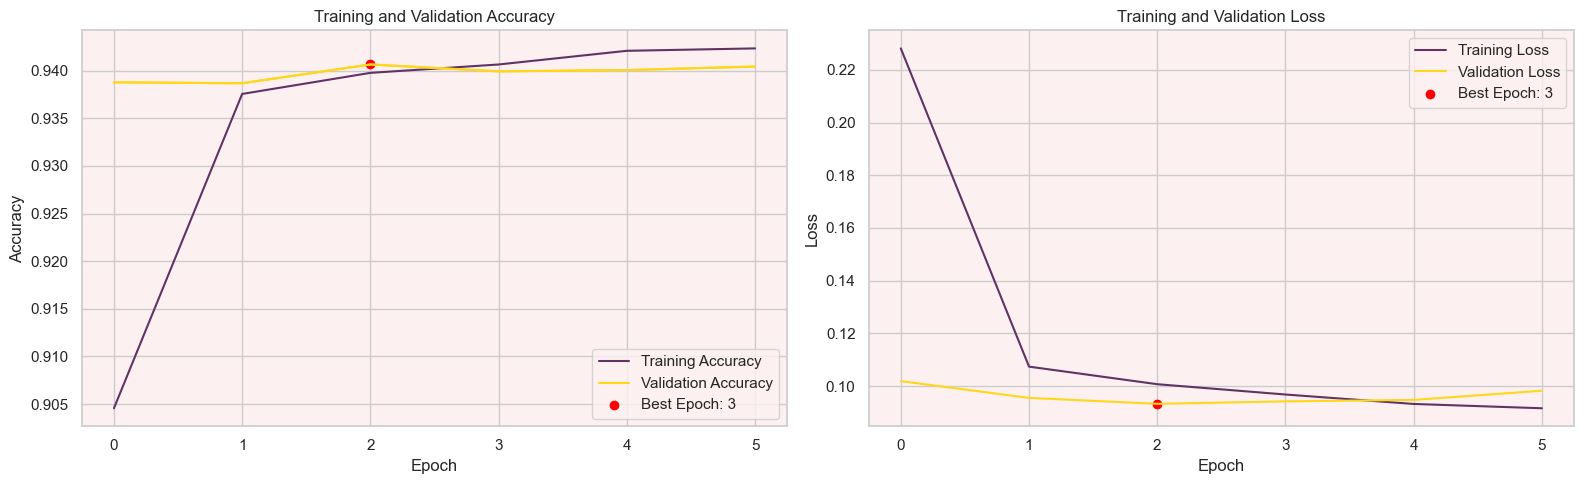

In [38]:
# Set the background color and theme
background_color = '#fcf1f0'
sns.set_theme(style="whitegrid", rc={"axes.facecolor": background_color})

# Get the epoch with the highest validation accuracy
best_epoch = history.history['val_accuracy'].index(max(history.history['val_accuracy'])) + 1


# Create a subplot with 1 row and 2 columns
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

# Plot training and validation accuracy
axs[0].plot(history.history['accuracy'], label='Training Accuracy', color='#5f3364')
axs[0].plot(history.history['val_accuracy'], label='Validation Accuracy', color='#fed71a')
axs[0].scatter(best_epoch - 1, history.history['val_accuracy'][best_epoch - 1], color='red', label=f'Best Epoch: {best_epoch}')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].set_title('Training and Validation Accuracy')
axs[0].legend()

# Plot training and validation loss
axs[1].plot(history.history['loss'], label='Training Loss', color='#5f3364')
axs[0].plot(history.history['val_accuracy'], label='Validation Accuracy', color='#fed71a')
axs[1].plot(history.history['val_loss'], label='Validation Loss', color='#fed71a')
axs[1].scatter(best_epoch - 1, history.history['val_loss'][best_epoch - 1], color='red',label=f'Best Epoch: {best_epoch}')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].set_title('Training and Validation Loss')
axs[1].legend()

plt.tight_layout()

import os

# 1. 确保目录存在
save_dir = r"D:\document\dissertation\LSTM_result"
os.makedirs(save_dir, exist_ok=True)

# 2. 修正保存路径
save_path = os.path.join(save_dir, "training_loss_accr.png")

# 3. 保存图片
plt.savefig(save_path)
plt.show()


In [39]:
# Evaluate Test Data 
model.evaluate(X_test_padded, y_test)

2601/2601 [==============================] - 39s 15ms/step - loss: 0.0982 - accuracy: 0.9404


[0.09820695966482162, 0.9404385685920715]

In [40]:
# Predictions On Test For Confustion Matrix 
y_pred = model.predict(X_test_padded)
y_pred = np.argmax(y_pred, axis=1)

2601/2601 [==============================] - 38s 14ms/step


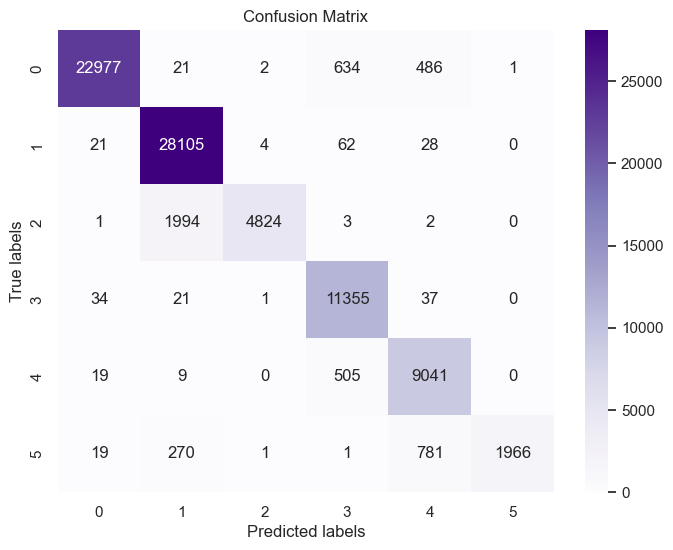

In [41]:
# y_test and y_pred are your true and predicted labels
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix with blue color
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples')  # Change 'Reds' to 'Blues' for blue color
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()




In [42]:
import os
import json

# 使用已有的保存目录
save_dir = r"D:\document\dissertation\LSTM_result"

# 保存完整模型
model_path = os.path.join(save_dir, "lstm_model.h5")
model.save(model_path)

# 保存训练历史
history_dict = history.history
history_path = os.path.join(save_dir, "training_history.json")
with open(history_path, 'w') as f:
    json.dump(history_dict, f)

print(f"模型已保存到: {model_path}")
print(f"训练历史已保存到: {history_path}")

模型已保存到: D:\document\dissertation\LSTM_result\lstm_model.h5
训练历史已保存到: D:\document\dissertation\LSTM_result\training_history.json


In [43]:
import os
import pickle

# 使用已有的保存目录
save_dir = r"D:\document\dissertation\LSTM_result"
os.makedirs(save_dir, exist_ok=True)

# 1. 保存 tokenizer
tokenizer_path = os.path.join(save_dir, "tokenizer.pickle")
with open(tokenizer_path, 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# 2. 保存模型配置（如果需要）
model_config = model.get_config()
config_path = os.path.join(save_dir, "model_config.pickle")
with open(config_path, 'wb') as handle:
    pickle.dump(model_config, handle, protocol=pickle.HIGHEST_PROTOCOL)

print(f"Tokenizer 已保存到: {tokenizer_path}")
print(f"模型配置已保存到: {config_path}")

Tokenizer 已保存到: D:\document\dissertation\LSTM_result\tokenizer.pickle
模型配置已保存到: D:\document\dissertation\LSTM_result\model_config.pickle
